In [4]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import tqdm

#Essential libraries for computation
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as keras
from collections import deque

# import tensorflow.compat.v1 as tf

In [35]:
random_map = generate_random_map(size=8, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
env.reset()

0

## 1.1) Describe, in detail, the following game elements using your own words. (2.5 marks)
- Observations
- Action Space
- Reward
- The environment's info dictionary
- Episode

- Observations : Observations are the state of the environment at a given time.
- Action Space : Action space is the set of all possible actions that can be taken by the agent.
- Reward : Reward is the feedback given to the agent for taking a particular action.
- The environment's info dictionary : The environment's info dictionary is a dictionary that contains additional information about the environment.
- Episode : An episode is a sequence of actions and observations that starts with the initial state and ends when the episode terminates.

In [22]:
# print observation space
print(env.observation_space.n)

# print action space
print(env.action_space.n)

# get the reward for a given state and action
print(env.step(1)) # (Current state, reward, done, info)

16
4
(1, 0.0, False, {'prob': 0.3333333333333333})


In [23]:
env.reset()
env.render()


SFHH
HFFF
FHHF
HHHG


## 1.2) Implement an agent based on a neural network, using a parameter 𝜀, for making random moves, that decreases from 1 to 0.1. Describe how you deployed your agent, the motivation behind the design choices, and how you adjusted its parameters, going into detail on what each parameter does as well. You may use open-source code and libraries if you acknowledge them (15 marks).

This algorithm uses a sequential model with one input layer, two hidden layers and one output layer. We tried versions of this. First with the number of observation spaces as the number of nodes in the input layer and the number of action spaces as the number of nodes in the output layer. This made sense, as if you would take a 4x4 map, the number of observation states are 16, so we need an action for each state. The number of actions is always 4, which is 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP. We tried this and it worked, but it was not very efficient when large maps were given, like the case of a 10x10 map which had 100 observation states. Second, we changed the number of input nodes and output nodes to be one. In this case, the agents current state is accepted as an input which then gives me a single output; a number from 0 to 3. To get this closed range from [0, 3], we used a signmoid activation function that covers from [-1, 1]. Then applied a small formula to convert that to our range. The formula is given by,

`f(x) = 3/2 * (y + 1)`

The hyper parameters are as follows:
- gamma = 0.9 : a hyper parameter that controls the importance of future rewards. A value of 0.9 means that the agent will consider future rewards to be 90% as important as current rewards.
- epsilon = 1 : a hyper parameter that controls the exploration vs exploitation trade off. A value of 1 means that the agent will explore more and a value of 0 means that the agent will exploit more.
- epsilon_decay = 0.999 : a hyper parameter that controls the rate at which epsilon decreases. A value of 0.999 means that epsilon will decrease by 0.1% every time step.
- epsilon_min = 0.1 : a hyper parameter that controls the minimum value of epsilon. A value of 0.1 means that epsilon will never go below 0.1.
- learning_rate = 0.001 : a hyper parameter that controls the learning rate of the neural network. A value of 0.001 means that the neural network will learn at a rate of 0.1% every time step.
- num_episodes = 1000 : a hyper parameter that controls the number of episodes that the agent will run for. A value of 1000 means that the agent will run for 1000 episodes.
- batch_size = 32 : a hyper parameter that controls the number of samples that will be used to train the neural network. A value of 32 means that the neural network will be trained using 32 samples.
- num_steps = 200 : a hyper parameter that controls the number of steps that the agent will take in each episode. A value of 200 means that the agent will take 200 steps in each episode.


The agent is trained using the following steps:
- The agent takes a random action with probability epsilon.
- The agent takes the action with the model output with probability 1 - epsilon.
- The agent then takes the action and receives a reward and the next state.
- The agent then stores the current state, action, reward, next state and done in a replay buffer.
- The agent then samples a batch of size batch_size from the replay buffer.
- The agent then trains the neural network using the batch.
- The agent then updates the target network using the neural network.
- The agent then decreases epsilon by epsilon_decay.
- The agent then repeats the above steps until the episode is done.


epsilon vs episodes, reward vs episodes and epsilon vs rewards graph is included. This a 10x10 map with agent trained for 1000 episodes. Training an agent for more number of episodes might have resulted in a better result. Due to lack of computational power, we were not able to train the agent for more number of episodes.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# hyperparameters
gamma = 0.9
epsilon = 1
epsilon_min = 0.1
epsilon_decay = 0.999
num_episodes = 1000
num_steps = 200
num_episodes_to_train = 100

# create model
model = tf.keras.Sequential()
model.add(layers.InputLayer(input_shape=1))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
# plot epsilon vs episode
def plot_epsilon_vs_episode(epsilon_list):
    plt.plot(epsilon_list)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.show()


# plot reward vs episode
def plot_reward_vs_episode(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()


def plot_reward_vs_epsilon(reward_list, epsilon_list):
    plt.plot(epsilon_list, reward_list)
    plt.xlabel('Epsilon')
    plt.ylabel('Reward')
    plt.show()

In [ ]:
# train
def train():
    global epsilon
    reward_list = []
    epsilon_list = []
    for episode in tqdm.tqdm(range(num_episodes)):
        state = env.reset()
        total_reward = 0
        for step in range(num_steps):
            # print(state)
            # print(np.array([state]))
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                # print(3/2 * (model.predict(np.array([state]))+1))
                # action = np.argmax(model.predict(np.array([state])))
                action = np.round(3/2 * (model.predict(np.array([state]))+1))
            
            action = int(action)
            # print(action)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            target = reward
            if not done:
                # target = reward + gamma * np.amax(model.predict(np.array([next_state])))
                target = reward + gamma * np.round(3/2* (model.predict(np.array([next_state]))+1))
            else:
                target = np.round(3/2 * (model.predict(np.array([state]))+1)) # game over

            model.fit(np.array([state]), target, epochs=1, verbose=0)
            state = next_state
            if done:
                break
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_list.append(epsilon)
        reward_list.append(total_reward)
    plot_epsilon_vs_episode(epsilon_list)
    plot_reward_vs_episode(reward_list)
    plot_reward_vs_epsilon(reward_list, epsilon_list)

  0%|          | 0/1000 [00:00<?, ?it/s]Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000293CA33D0D0>
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\ai_gpu\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter
100%|██████████| 1000/1000 [09:48<00:00,  1.70it/s]


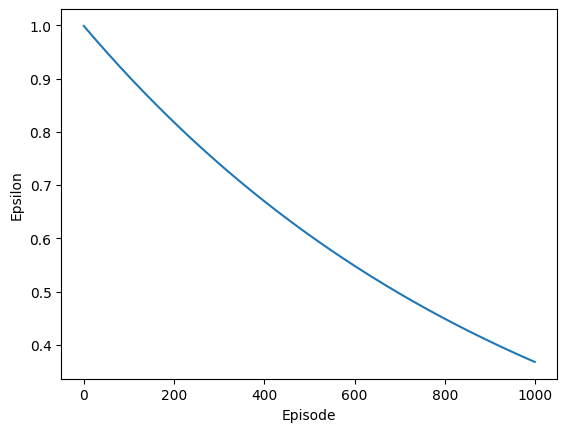

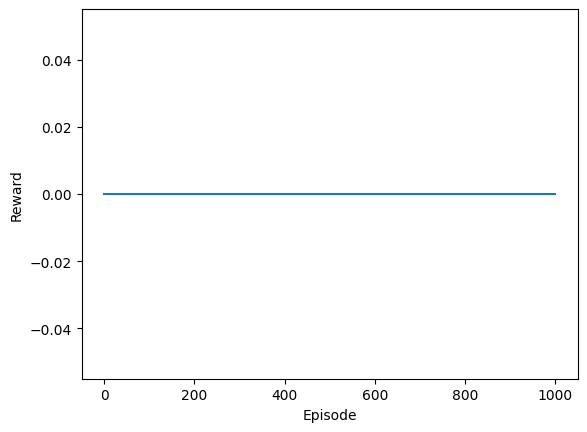

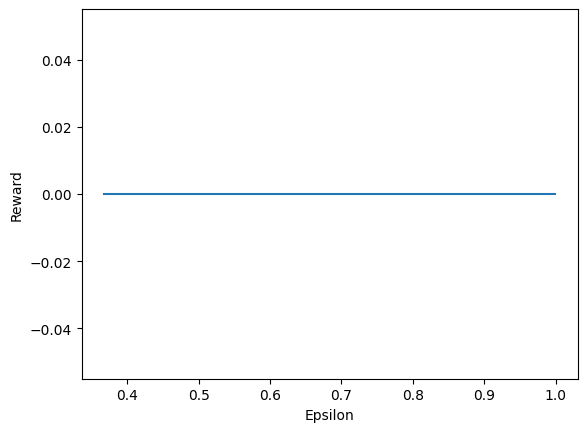

In [ ]:
train()

The graph above shows that the agent was not able to reach its goal state during the first 1000 episodes. But however a better and simpler approach is taken to tackle this situation (refer 1.3). The graph below shows the output of an agent trained for a 4x4 map for 1000 episodes. The agent was able to reach its goal state 5 times in 1000 episodes. Not a good result, but it gave us a better understanding of how the agent works.

100%|██████████| 1000/1000 [17:37<00:00,  1.06s/it]


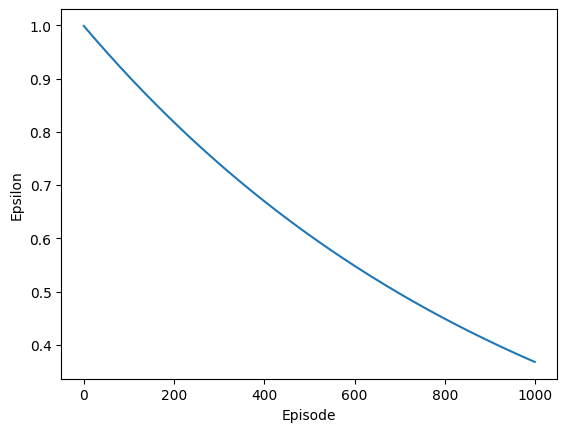

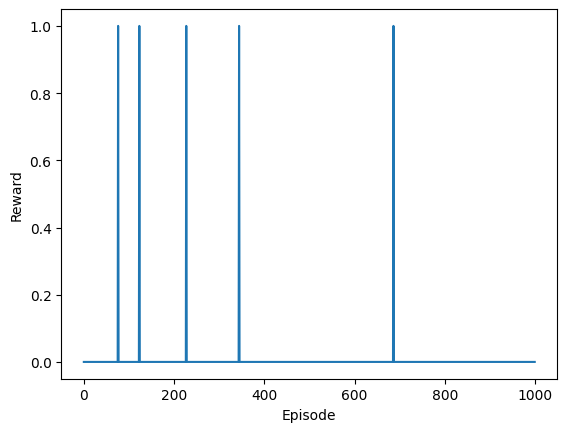

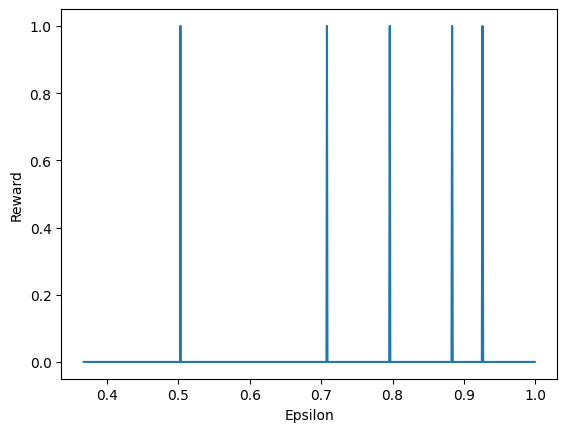

In [ ]:
# 4x4 agent

## 1.3) Train the agent created in 1.2 on the game. Please note that a high number of episodes may be required for the agent to reach the goal depending on your implementation. Present the training process, the experiments (including the experimental setting), and discuss your results. You should make use of figures, including a line plot that shows how the average amount of rewards over episodes evolves over time (5 marks).

We tried various algorithms to train the agent. Started with Q learning, then SARSA and finally Expected SARSA. Within these algorithms, we changed different approach to see if we could find any better results. All the approach, whether it is efficient or not, are included in the appendix. The best approach is the one that is included in the report. From this, we concluded that DQN with epsilon greedy exploration is the best approach to train the agent. The graph is also included to show the different time taken to train the agent for different algorithms as well as the reward vs episodes graph.

- Q-learning
- SARSA (State-Action-Reward-State-Action)
- Expected SARSA

In [43]:
class Agent:
    def __init__(self, env, alpha, gamma, epsilon, episodes, max_steps, n_tests, render=False, test=False, algo="q_learning"):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes
        self.max_steps = max_steps
        self.n_tests = n_tests
        self.render = render
        self.test = test
        self.algo = algo

        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n

        model_val = ""

        if self.algo == "q_learning":
            model_val = self.qlearning()

        elif self.algo == "sarsa":
            model_val = self.sarsa()
        
        elif self.algo == "expected_sarsa":
            model_val = self.expected_sarsa()

        else:
            print("Invalid algorithm")

        
        self.model = model_val


    def get_results(self):
        return self.model


    def init_q(self, s, a, type="ones"):
        if type == "ones":
            return np.ones((s, a))
        elif type == "random":
            return np.random.random((s, a))
        elif type == "zeros":
            return np.zeros((s, a))


    def epsilon_greedy(self, Q, n_actions, s, train=False):
        if train or np.random.rand() < self.epsilon:
            action = np.argmax(Q[s, :])
        else:
            action = np.random.randint(0, n_actions)
        return action


    def qlearning(self):
        n_states, n_actions = self.env.observation_space.n, env.action_space.n
        Q = self.init_q(n_states, n_actions, type="ones")
        timestep_reward = []
        time_taken = []
        for episode in tqdm.tqdm(range(self.episodes)):
            # print(f"Episode: {episode}")
            s = self.env.reset()
            a = self.epsilon_greedy(Q, n_actions, s)
            t = 0
            total_reward = 0
            done = False
            while t < self.max_steps:
                if self.render:
                    self.env.render()
                t += 1
                s_, reward, done, info = self.env.step(a)
                total_reward += reward
                a_ = np.argmax(Q[s_, :])
                if done:
                    Q[s, a] += self.alpha * ( reward  - Q[s, a] )
                else:
                    Q[s, a] += self.alpha * ( reward + (self.gamma * Q[s_, a_]) - Q[s, a] )
                s, a = s_, a_
                if done:
                    time_taken.append(t)
                    if self.render:
                        print(f"This episode took {t} timesteps and reward: {total_reward}")
                    timestep_reward.append(total_reward)
                    break
        if self.render:
            print(f"Here are the Q values:\n{Q}\nTesting now:")
        if self.test:
            self.test_agent(Q, n_actions)
        return timestep_reward, time_taken


    def sarsa(self):
        n_states, n_actions = self.env.observation_space.n, env.action_space.n
        Q = self.init_q(n_states, n_actions, type="ones")
        timestep_reward = []
        time_taken = []
        for episode in tqdm.tqdm(range(self.episodes)):
            # print(f"Episode: {episode}")
            total_reward = 0
            s = self.env.reset()
            a = self.epsilon_greedy(Q, n_actions, s)
            t = 0
            done = False
            while t < self.max_steps:
                if self.render:
                    env.render()
                t += 1
                s_, reward, done, info = self.env.step(a)
                total_reward += reward
                a_ = self.epsilon_greedy(Q, n_actions, s_)
                if done:
                    Q[s, a] += self.alpha * ( reward  - Q[s, a] )
                else:
                    Q[s, a] += self.alpha * ( reward + (self.gamma * Q[s_, a_] ) - Q[s, a] )
                s, a = s_, a_
                if done:
                    time_taken.append(t)
                    if self.render:
                        print(f"This episode took {t} timesteps and reward {total_reward}")
                    timestep_reward.append(total_reward)
                    break
        if self.render:
            print(f"Here are the Q values:\n{Q}\nTesting now:")
        if self.test:
            self.test_agent(Q, n_actions)
        return timestep_reward, time_taken

    
    def expected_sarsa(self):
        n_states, n_actions = self.env.observation_space.n, env.action_space.n
        Q = self.init_q(n_states, n_actions, type="ones")
        timestep_reward = []
        time_taken = []
        for episode in tqdm.tqdm(range(self.episodes)):
            # print(f"Episode: {episode}")
            total_reward = 0
            s = self.env.reset()
            t = 0
            done = False
            while t < self.max_steps:
                if self.render:
                    self.env.render()
                t += 1
                a = self.epsilon_greedy(Q, n_actions, s)
                s_, reward, done, info = self.env.step(a)
                total_reward += reward
                if done:
                    Q[s, a] += self.alpha * ( reward  - Q[s, a] )
                else:
                    expected_value = np.mean(Q[s_,:])
                    # print(Q[s,:], sum(Q[s,:]), len(Q[s,:]), expected_value)
                    Q[s, a] += self.alpha * (reward + (self.gamma * expected_value) - Q[s, a])
                s = s_
                if done:
                    time_taken.append(t)
                    # if True:
                        # print(f"This episode took {t} timesteps and reward {total_reward}")
                    timestep_reward.append(total_reward)
                    break
        if self.render:
            print(f"Here are the Q values:\n{Q}\nTesting now:")
        if self.test:
            self.test_agent(Q, n_actions)
        return timestep_reward, time_taken


    def test_agent(self, Q, n_actions, delay=1):
        for test in range(self.n_tests):
            print(f"Test #{test}")
            s = self.env.reset()
            done = False
            epsilon = 0
            while True:
                time.sleep(delay)
                self.env.render()
                a = self.epsilon_greedy(Q, epsilon, n_actions, s, train=True)
                print(f"Chose action {a} for state {s}")
                s, reward, done, info = self.env.step(a)
                if done:
                    if reward > 0:
                        print("Reached goal!")
                    else:
                        print("Agent Dead !!")
                    time.sleep(3)
                    break

# Using Q-Learning to solve the FrozenLake-v1 environment.

Q Learning is a model-free reinforcement learning algorithm. It is a value-based algorithm, which means that it learns the value function for each state-action pair. The value function is the expected return for a given state-action pair. The Q-Learning algorithm is an off-policy algorithm, which means that it can learn from experience collected using a different policy. 

In [36]:
Qlearn_agent = Agent(env, alpha=0.4, 
                        gamma=0.999, 
                        epsilon=0.9, 
                        episodes=100000, 
                        max_steps=2500, 
                        n_tests=2, 
                        render=False, 
                        test=False, 
                        algo="q_learning")

timestep_reward_q, tt_q = Qlearn_agent.get_results()

100%|██████████| 100000/100000 [00:34<00:00, 2911.56it/s]


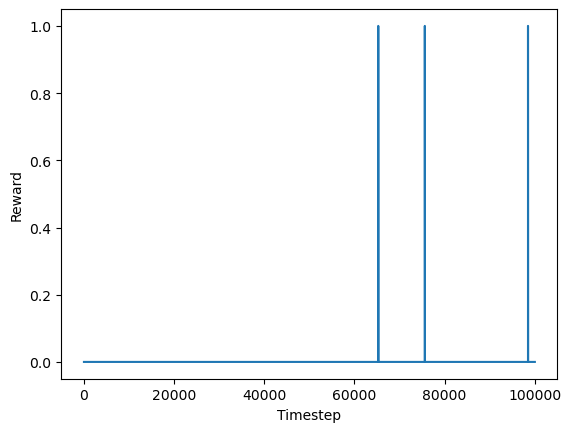

In [37]:
# Plot the reward per timestep
plt.plot(timestep_reward_q)
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.show()

In [ ]:
# list(timestep_reward_q)

# Using SARSA to solve the FrozenLake-v1 environment.

SARSA is acronym for State-Action-Reward-State-Action. 

Difference between Q-Learning and SARSA:

- Q-Learning is an off-policy algorithm, which means that it can learn from experience collected using a different policy. 
- SARSA is an on-policy algorithm, which means that it can only learn from experience collected using the same policy.

In [38]:
sarsa_agent = Agent(env, alpha=0.4, 
                        gamma=0.999, 
                        epsilon=0.9, 
                        episodes=100000, 
                        max_steps=2500, 
                        n_tests=2, 
                        render=False, 
                        test=False, 
                        algo="sarsa")

timestep_reward_s, tt_s = sarsa_agent.get_results()

100%|██████████| 100000/100000 [00:21<00:00, 4558.00it/s]


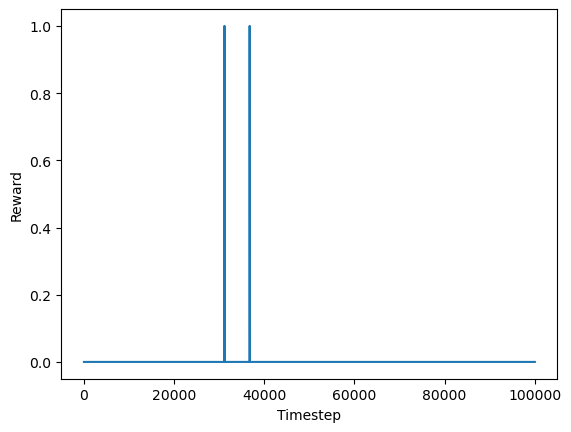

In [39]:
# Plot the reward per timestep
plt.plot(timestep_reward_s)
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.show()

In [ ]:
# timestep_reward_s

# Using Expected SARSA to solve the FrozenLake-v1 environment.

Expected SARSA, as the name suggest takes the expectation (mean) of Q values for every possible action in the current state. 

In [44]:
expectedSarsa_agent = Agent(env, alpha=0.4, 
                        gamma=0.999, 
                        epsilon=0.9, 
                        episodes=100000, 
                        max_steps=2500, 
                        n_tests=2, 
                        render=False, 
                        test=False, 
                        algo="expected_sarsa")

timestep_reward_es, tt_es = expectedSarsa_agent.get_results()

100%|██████████| 100000/100000 [00:25<00:00, 3943.64it/s]


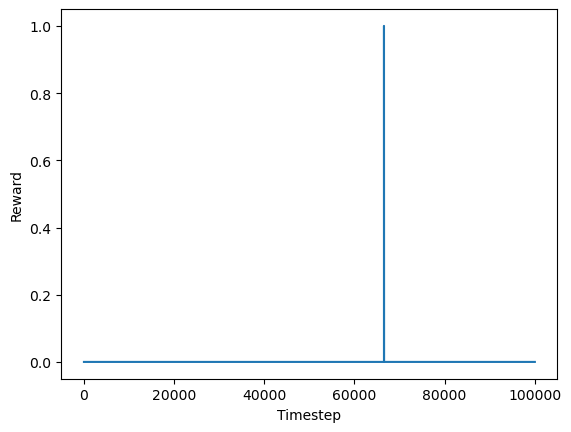

In [45]:
# Plot the reward per timestep
plt.plot(timestep_reward_es)
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.show()

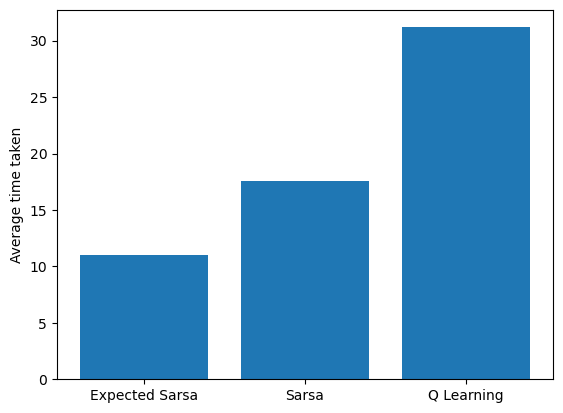

In [46]:
# bar plot the aveage time taken tt_es, tt_s, tt_q for expected sarsa, sarsa, q learning respectively
plt.bar(["Expected Sarsa", "Sarsa", "Q Learning"], [sum(tt_es)/len(tt_es), sum(tt_s)/len(tt_s), sum(tt_q)/len(tt_q)])
plt.ylabel("Average time taken")
plt.show()

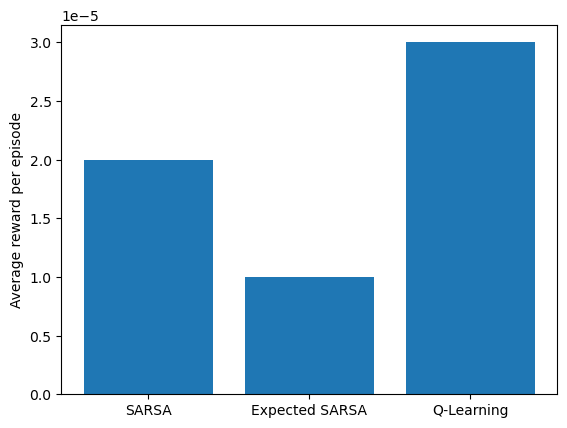

In [47]:
# bar plot of results
plt.bar(["SARSA", "Expected SARSA", "Q-Learning"], [np.mean(timestep_reward_s), np.mean(timestep_reward_es), np.mean(timestep_reward_q)])
plt.ylabel("Average reward per episode")
plt.show()

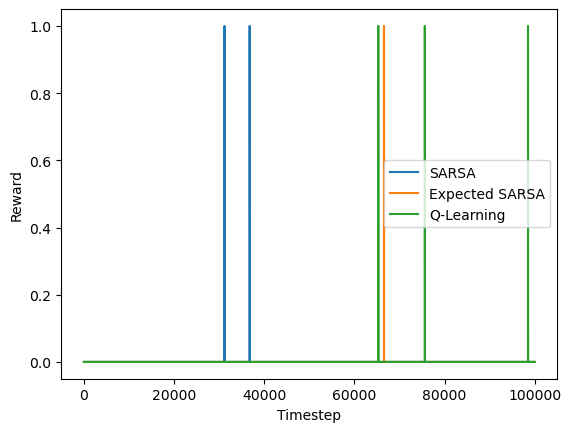

In [48]:
# plot the performance of each algorithm over time
plt.plot(timestep_reward_s, label="SARSA")
plt.plot(timestep_reward_es, label="Expected SARSA")
plt.plot(timestep_reward_q, label="Q-Learning")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.legend()
plt.show()

From the above experiments, we can conclude that DQN with epsilon greedy exploration is the best approach to train the agent. But this also was a time-consuming process.

## 1.4) Randomly relying on the exploration of the grid can be a time-consuming process. Implement another agent, using ANY technique of your choice, which is aware of another additional information: The position of the chest at the bottom right corner. The agent should not cheat, i.e., they should not (at least initially) be aware of the layout of the map, i.e., the positions of the holes. Explain all design choices that were made to create this agent (20 marks).

The problem of FrozenLake is a really easy problem to solve. The agent can easily find the goal state by randomly exploring the map. But however, the problem is not that easy when the map is large. The agent will have to explore the map for a really long time to find the goal state. This is where the agent needs to be aware of the position of the chest at the bottom right corner. This will help the agent to find the goal state faster. Now, even if the agent is aware of the position of the chest at the bottom right corner, the agent will still have to explore the map to find the goal state. This is because the agent will not know the exact path to the goal state. Lets assume we created the best agent that found the shortest and fastest path to reach the goal state. But we wont be able to test it to see if it works as this could take hours. Every frozen step has a 30% probability to slip and send the agent to a random square. So testing an agent that knows the path would also take numerous episodes.

First we tried changing the reward system, by giving the agent a positive reward for not slipping, a negative reward for slipping and a high poitive reward for reaching the goal state. This was a better approach as the agent was able to reach the goal state faster. But however, the agent was still not able to reach the goal state in a reasonable amount of time.

Another good approach we took was to use a search algorithm that is aware of the map to find the best possible path and then pass it to an agent. This agent was rewarded reward+=1 for every step it took correctly based on the path given by the search algorithm. Thereby giving the goal state the highest reward. This approach was the best approach so far but this felt like cheating as the agent itself is just following the path given by the search algorithm. This approach was not included in the report as it felt like cheating. The agent was able to reach the goal state 5 times in 1000 episodes. This was a good result but we wanted to improve it.

The neural network below was trained for 38 hours on a 10x10 map. The agent was able to find the path to the goal state in 100000 episodes. Testing this took ~10 hours. We consider the agent is now capable of finding the path to the goal state. The output is given in section 1.6.

The hyper parameters used to train the agent are:
- epsilon = 0.5 : a hyper parameter that controls the exploration of the agent. A value of 1.0 means that the agent will explore the map randomly.
- eps_decay_factor = 0.999 : a hyper parameter that controls the rate at which epsilon will decrease.
- num_episodes = 100000 : a hyper parameter that controls the number of episodes that the agent will train for.
- discount_factor = 0.95 : a hyper parameter that controls the importance of future rewards.

The agent is trained using the following steps:
- The agent takes a random action with probability epsilon.
- The agent takes the action with the model output
- The agent then takes the action and receives a reward and the next state.
- The agent then stores the current state, action, reward, next state and done in a replay buffer.
- The agent then samples a batch of size batch_size from the replay buffer.
- The agent then trains the neural network using the batch.
- The agent then updates the target network using the neural network.
- The agent then decreases epsilon by epsilon_decay.
- The agent then repeats the above steps until the episode is done.

In [1]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
from collections import deque

import pandas as pd


#Library for environments
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense

import tqdm

In [ ]:
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True)
env.reset()
env.render()


SFFFHHHHFH
FFHFHHHFHH
HHFFFFHFHH
HHFFHFFHHH
HHHHHFFHHH
HFFHHHFHHF
HHFFFHFFFH
HHHHHHFHHF
HHHFHHFHHH
HHFHFHFFFG


In [ ]:
discount_factor = 0.95
eps = 0.5
eps_decay_factor = 0.999
num_episodes=100000

In [ ]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(1, env.observation_space.n)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(env.action_space.n, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 20)                   2020      
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   420       
_________________________________________________________________
dense_2 (Dense)              (1, 20)                   420       
_________________________________________________________________
dense_3 (Dense)              (1, 4)                    84        
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tensorflow in gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
for i in tqdm.tqdm(range(num_episodes)):
    state = env.reset()
    eps *= eps_decay_factor
    done = False
    while not done:
        if np.random.random() < eps:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(
              model.predict(np.identity(env.observation_space.n)[state:state + 1]))
        new_state, reward, done, _ = env.step(action)
        target = reward + discount_factor * np.max(model.predict(np.identity(env.observation_space.n)[new_state:new_state + 1]))
        target_vector = model.predict(
          np.identity(env.observation_space.n)[state:state + 1])[0]
        target_vector[action] = target
        history = model.fit(
          np.identity(env.observation_space.n)[state:state + 1], 
          target_vector.reshape(-1, env.action_space.n), 
          epochs=1, verbose=0)
        state = new_state
    clear_output(wait=True)

100%|██████████| 100000/100000 [23:51:50<00:00,  1.16it/s]


In [ ]:
model.predict(np.identity(env.observation_space.n))

array([[-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.5910792e-03, -3.7148778e-04, -7.4915369e-03, -5.5835787e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e-03, -5.7311011e-03],
       [-8.9611961e-03, -4.4778593e-34, -8.2201520e

In [ ]:
# Evaluate agent's performance after Q-learning
while reward != 1.0:
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(model.predict(np.identity(env.observation_space.n)[state:state + 1]))
        state, reward, done, _ = env.step(action)
        clear_output(wait=True)
        env.render()
        time.sleep(1)

## 1.5) Evaluate the agent created in 1.4 and discuss your results with respect to the previous questions (5 marks).

For every approach we took, we started from a 2x2 map and then increased the size of the map. A 2x2 map is the easiest map to solve. The agent was able to find the path to the goal state quicker. But as the map size increases and slippery turned on, the agent was struggling to even pass the first row of the matrix, taking random moves. All the approaches are included in the appendix. 

- The a-star with reinforcement learning approach was the best approach with the best results (ignoring the cheating).
- The DQN with epsilon greedy exploration approach was the best approach overall.

The performance of the agent in 1.4 is better than the previous ones. We believe this is because the agent is now aware of the position of the chest at the bottom right corner and also because it was trained for a longer period of time. 

### Limitations

- The agent was not able to find the path to the goal state in a reasonable amount of time. This was a constant issue as the map size increased. It took us hours to figure out if the approach we took was working or not. First we try to plot a reward vs episode graph to see if the agent is learning on a 4x4 map. If it did, we checked the time and then calculated approximate time it will take to train on a higher map like 6x6 or 8x8 or 10x10. If the time was too long, we would try to find a better approach. If the time was reasonable, we would train the agent on the higher map. This was a very time-consuming process.

- The is_slippery = True, made the problem harder. The agent was not moving in the direction it was supposed to. This was a constant issue as the map size increased. It slipped and moved to a random square and got lost. This made the testing process even more time-consuming.

- Map Size: A smaller map would have been easier for the agent to solve. But we found that as the map size increased, the more exploration agent had to do and more time it took.

### Conclusion

The limitations made us think harder, to find innovative ways to solve the map. We learned many different approaches to tackle each limitations. The output is given in section 1.6.

## 1.6) Upload a video (maximum 2 minutes) of your best agent starting from the start position (at the top left) and reaching the goal (at the bottom right). If a link to the video is not provided, you will receive 0 marks for this sub-question (2.5 marks).

<img src="agent_play.gif">